In [3]:
## Tools 

from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

d:\Langgraph\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [4]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max= 500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv, description="Query arxiv papers")
print(arxiv.name)

arxiv


In [5]:
arxiv.invoke('Attention is all you need')

'Published: 2021-05-06\nTitle: Do You Even Need Attention? A Stack of Feed-Forward Layers Does Surprisingly Well on ImageNet\nAuthors: Luke Melas-Kyriazi\nSummary: The strong performance of vision transformers on image classification and other vision tasks is often attributed to the design of their multi-head attention layers. However, the extent to which attention is responsible for this strong performance remains unclear. In this short report, we ask: is the attention layer even necessary? Specifi'

In [6]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper = api_wrapper_wiki)
wiki.name

'wikipedia'

In [7]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv('TAVILY_API_KEY')
os.environ['GROQ_API_KEY'] = os.getenv('GROQ_API_KEY')

In [8]:
# Tavilly Search Tool
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\hp\AppData\Local\Temp\ipykernel_15600\2728711861.py:4: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [9]:
tavily.invoke("Provide me the recent AI agents")

[{'title': 'AI Engineering Trends in 2025: Agents, MCP and Vibe Coding',
  'url': 'https://thenewstack.io/ai-engineering-trends-in-2025-agents-mcp-and-vibe-coding/',
  'content': 'Although agents had been talked about last year, 2025 was when talk became action. It probably started when OpenAI launched Operator as a research preview on January 23, 2025. It was pitched as an AI agent capable of using its own web browser to perform tasks like filling in forms, making purchases, and scheduling appointments. Operator was followed in July by ChatGPT agent, which boasted of an internal “virtual computer” for task execution. [...] When I went to the first AI Engineer Summit in October 2023, AI agents were a joke. At that point, agents hadn’t proven they could consistently do even basic tasks. But fast forward just two years, and agentic technology has made big strides — albeit it’s still relatively unproven as completely autonomous software. Regardless, agents were the biggest development sto

In [10]:
# combine all these tools in the list

tools = [arxiv, wiki, tavily]

In [11]:
# Initialize the LLM Model
from langchain_groq import ChatGroq

llm=ChatGroq(model='qwen/qwen3-32b')

In [12]:
llm.invoke("What is AI")

AIMessage(content='<think>\nOkay, the user is asking what AI is. Let me start by defining it clearly. AI, or Artificial Intelligence, is a field in computer science focused on creating systems that can perform tasks typically requiring human intelligence. I should mention the key areas like learning, reasoning, problem-solving, perception, and language understanding. Maybe break it down into machine learning, deep learning, natural language processing, computer vision, and robotics. Need to explain each briefly. Also, give examples of real-world applications like virtual assistants, recommendation systems, autonomous vehicles, and medical diagnostics. It\'s important to note that AI can be narrow (focused on specific tasks) or general (hypothetical systems with human-like capabilities). Clarify the difference between AI and human intelligence. Mention the history a bit, like when the term was coined in 1956. Address current trends and challenges, such as ethical concerns and data requi

In [13]:
llm_with_tools = llm.bind_tools(tools=tools)

In [14]:
# execute this call

llm_with_tools.invoke("What is the recent news on AI?")

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for recent news on AI. I need to figure out which tool to use here. Let me check the available tools. There\'s arxiv, wikipedia, and tavily_search_results_json. Arxiv is for academic papers, wikipedia for general knowledge, and tavily is described as a search engine for current events. Since the user is asking about recent news, which is likely to be current events, tavily_search_results_json seems like the right choice. I should use that to get the latest information. The query parameter should be "recent news on AI". Let me structure the tool call accordingly.\n', 'tool_calls': [{'id': 'fg4mg5xdm', 'function': {'arguments': '{"query":"recent news on AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 354, 'total_tokens': 511, 'completion_time': 0.269721048, 'completion_tokens_details': {'reasoning_tokens

## Workflow

In [15]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage # human message or ai message
from typing import Annotated # labelling
from langgraph.graph.message import add_messages # reducers in langgrah

In [16]:
# state schema 
class State(TypedDict):
    messages: list[Annotated[AnyMessage, add_messages]] ## list of messages (append the messages instead of over writing)
    

In [17]:
## Entire Chatbot 
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

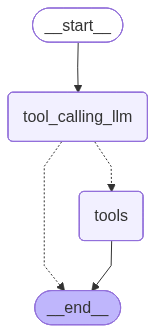

In [18]:
## Node definition
def tool_calling_llm(state:State):
    return {'messages': [llm_with_tools.invoke(state['messages'])]}

## Build graph
builder = StateGraph(State)
builder.add_node('tool_calling_llm',tool_calling_llm)
builder.add_node('tools', ToolNode(tools))

## Edges
builder.add_edge(START, 'tool_calling_llm')
builder.add_conditional_edges(
    'tool_calling_llm',
    tools_condition,
)
builder.add_edge('tools',END)

# compile
graph = builder.compile()

# view 
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
# graph.invoke({'messages': 'What is AI'})

In [20]:
messages = graph.invoke({'messages':'1706.03762'})
for m in messages['messages']:
    m.pretty_print()

================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, base


In [21]:
messages = graph.invoke({'messages':'Hi my name is A'})
for m in messages['messages']:
    m.pretty_print()

================================== Ai Message ==================================

Hello A! How can I assist you today?


In [22]:
messages = graph.invoke({'messages':'Write a Code for a simple portfolio43'})
for m in messages['messages']:
    m.pretty_print()

================================== Ai Message ==================================

Here's a simple portfolio template using HTML and CSS:

```html
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>My Simple Portfolio</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            line-height: 1.6;
        }

        header {
            background: #333;
            color: #fff;
            padding: 20px 0;
            text-align: center;
        }

        nav {
            margin-top: 10px;
        }

        nav a {
            color: #fff;
            margin: 0 15px;
            text-decoration: none;
        }

        .container {
            padding: 20px;
            max-width: 1000px;
            margin: auto;
        }

        .projects {
            display: grid;
            grid-template-columns: re